In [2]:
# AlexNet Pretrained Model Test on ImageNet-1K
import torch
from torchvision import models
from torchvision.models import AlexNet_Weights

# Load pretrained AlexNet
model = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
model.eval()

# Check available keys in the metadata
print("Available metadata keys:", AlexNet_Weights.IMAGENET1K_V1.meta.keys())

# Use an existing key or handle the missing key
acc1 = AlexNet_Weights.IMAGENET1K_V1.meta.get("acc@1", "Key not found")
print(f"AlexNet Top-1 Accuracy on ImageNet-1K: {acc1}")

Available metadata keys: dict_keys(['num_params', 'min_size', 'categories', 'recipe', '_metrics', '_ops', '_file_size', '_docs'])
AlexNet Top-1 Accuracy on ImageNet-1K: Key not found


In [23]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import alexnet, AlexNet_Weights
from torch.utils.data import DataLoader
import tqdm

# Load pretrained AlexNet
weights = AlexNet_Weights.IMAGENET1K_V1
model = alexnet(weights=weights)
model.eval()  # inference mode

# Define preprocessing (same as used during training of AlexNet)
preprocess = weights.transforms()

In [24]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class ImageNetValDataset(Dataset):
    def __init__(self, img_dir, label_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        
        # Load labels
        with open(label_file, "r") as f:
            self.labels = [int(line.strip().split()[1]) for line in f.readlines()]
        
        # Assume images are in alphabetical order (ILSVRC2012 convention: ILSVRC2012_val_00000001.JPEG ...)
        self.img_files = sorted(os.listdir(img_dir))
        assert len(self.img_files) == len(self.labels), "Mismatch between images and labels"

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label


In [25]:
device = torch.device("cpu")


In [46]:
from torch.utils.data import DataLoader
from torchvision.models import alexnet, AlexNet_Weights

# Load pretrained AlexNet
weights = AlexNet_Weights.IMAGENET1K_V1
model = alexnet(weights=weights).to(device).eval()

# Preprocessing (same normalization as training)
transform = weights.transforms()

# Path setup
val_img_dir = "./data/mp2/ILSVRC2012_img_val"          # directory with all 50k images
val_label_file = "./data/mp2/val.txt"  # file with 50k labels (one per line)
# Dataset + Loader
val_dataset = ImageNetValDataset(val_img_dir, val_label_file, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

Label: three-toed sloth


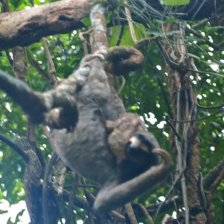

Label: hamster


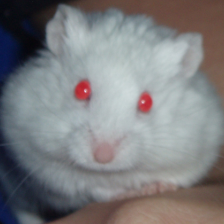

Label: cassette player


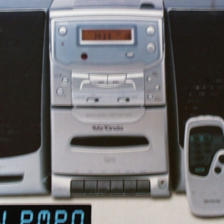

Label: parachute


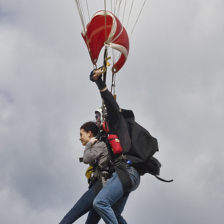

Label: scuba diver


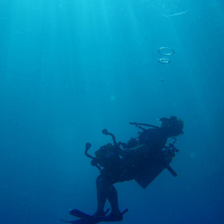

In [27]:
import random
from torchvision.transforms.functional import to_pil_image

# Select 5 random indices
random_indices = random.sample(range(len(val_dataset)), 5)
categories = weights.meta.get('categories')
# Display and print labels for the selected images
for idx in random_indices:
    image, label = val_dataset[idx]
    print(f"Label: {categories[label]}")
    # Denormalize the image
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    denormalized_image = image * std.view(3, 1, 1) + mean.view(3, 1, 1)

    # Display the denormalized image
    display(to_pil_image(denormalized_image))

In [54]:
len(val_dataset.labels)

50000

In [26]:
for images, labels in tqdm.tqdm(val_loader):
    print(images.shape, labels.shape)


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]

torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([36, 3, 224, 224]) torch.Size([36])


In [ ]:
import tqdm

correct_top1 = 0
correct_top5 = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm.tqdm(val_loader):
        images = images.to(device)
        outputs = model(images)
        if total >= 100:
            break

        _, pred_top1 = outputs.topk(1, dim=1)
        _, pred_top5 = outputs.topk(5, dim=1)

        labels = labels.to(device)  # Move labels to the same device as images and model
        total += labels.size(0)
        correct_top1 += (pred_top1.squeeze() == labels).sum().item()
        correct_top5 += sum([labels[i].item() in pred_top5[i] for i in range(labels.size(0))])

acc1 = 100 * correct_top1 / total
acc5 = 100 * correct_top5 / total

print(f"Top-1 Accuracy: {acc1:.3f}%")
print(f"Top-5 Accuracy: {acc5:.3f}%")


100%|██████████| 391/391 [09:21<00:00,  1.44s/it]

Top-1 Accuracy: 56.552%
Top-5 Accuracy: 79.092%


In [103]:
import numpy as np
from typing import Union, Tuple
import torch
import torch.nn.functional as F
from einops import rearrange, reduce

def conv2d(input, weight, bias, stride=1, padding=0):
    # Add padding to the input
    if padding > 0:
        input = np.pad(input, ((0, 0), (0, 0), (padding, padding), (padding, padding)), mode='constant')
    
    # Extract dimensions
    batch_size, in_channels, in_height, in_width = input.shape
    out_channels, _, kernel_height, kernel_width = weight.shape
    
    # Calculate output dimensions
    out_height = (in_height - kernel_height) // stride + 1
    out_width = (in_width - kernel_width) // stride + 1
    
    # Extract image patches using stride tricks
    shape = (batch_size, in_channels, out_height, out_width, kernel_height, kernel_width)
    strides = (input.strides[0], input.strides[1], stride * input.strides[2], 
               stride * input.strides[3], input.strides[2], input.strides[3])
    
    patches = np.lib.stride_tricks.as_strided(input, shape=shape, strides=strides)
    
    # Perform convolution using einsum
    # einsum pattern: batch, out_h, out_w, in_ch, kh, kw × out_ch, in_ch, kh, kw -> batch, out_ch, out_h, out_w
    output = np.einsum('bcHWij,ocij->boHW', patches, weight, optimize=True)
    # Add bias
    output += bias.reshape(1, out_channels, 1, 1)
    
    return output


def relu(input):
    return np.maximum(0, input)

# def max_pool2d(input, kernel_size, stride):
#     # Extract dimensions
#     batch_size, channels, in_height, in_width = input.shape
#     out_height = (in_height - kernel_size) // stride + 1
#     out_width = (in_width - kernel_size) // stride + 1
    
#     # Initialize output
#     output = np.zeros((batch_size, channels, out_height, out_width))
    
#     # Perform max pooling
#     for b in range(batch_size):
#         for c in range(channels):
#             for h in range(out_height):
#                 for w in range(out_width):
#                     h_start = h * stride
#                     w_start = w * stride
#                     h_end = h_start + kernel_size
#                     w_end = w_start + kernel_size
#                     output[b, c, h, w] = np.max(input[b, c, h_start:h_end, w_start:w_end])
#     return output

def flatten(input):
    return input.reshape(input.shape[0], -1)

def linear(input, weight, bias):
    return np.dot(input, weight.T) + bias



def _pair(x: Union[int, Tuple[int,int]]) -> Tuple[int,int]:
    if isinstance(x, int):
        return (x, x)
    if isinstance(x, tuple) and len(x) == 2:
        return x
    raise ValueError("kernel_size/stride must be int or tuple of two ints")

def max_pool2d(input: np.ndarray, 
               kernel_size: Union[int, Tuple[int,int]],
               stride: Union[int, Tuple[int,int]] = None) -> np.ndarray:
    """
    Max pooling implemented using einops and torch.nn.functional.unfold.
    Input/Output are numpy arrays.

    Args:
        input: numpy array of shape (N, C, H, W)
        kernel_size: int or (kh, kw)
        stride: int or (sh, sw). If None, defaults to kernel_size.

    Returns:
        numpy array of shape (N, C, H_out, W_out)
    """
    if input.ndim != 4:
        raise ValueError("input must be a 4D array (N, C, H, W)")

    kh, kw = _pair(kernel_size)
    if stride is None:
        sh, sw = kh, kw
    else:
        sh, sw = _pair(stride)

    # Convert numpy -> torch
    x = torch.from_numpy(input).float()

    N, C, H, W = x.shape

    # Extract sliding patches
    patches = F.unfold(x, kernel_size=(kh, kw), stride=(sh, sw))

    # Compute output spatial dims
    H_out = (H - kh) // sh + 1
    W_out = (W - kw) // sw + 1

    # Rearrange to group patches
    patches = rearrange(patches, 'n (c k) (h w) -> n c k h w',
                        c=C, k=kh*kw, h=H_out, w=W_out)

    # Max over patch elements
    out = reduce(patches, 'n c k h w -> n c h w', 'max')

    # Convert back to numpy
    return out.numpy()



In [100]:

class AlexNetNumpy:
    def __init__(self, weights):
        self.weights = weights

    def forward(self, x):
        # Layer 1: Convolution + ReLU + Max Pooling
        x = conv2d(x, self.weights['features.0.weight'], self.weights['features.0.bias'], stride=4, padding=2)  # Expected shape: (1, 64, 55, 55)
        x = relu(x)  # Expected shape: (1, 64, 55, 55)
        x = max_pool2d(x, kernel_size=3, stride=2)  # Expected shape: (1, 64, 27, 27)

        # Layer 2: Convolution + ReLU + Max Pooling
        x = conv2d(x, self.weights['features.3.weight'], self.weights['features.3.bias'], stride=1, padding=2)  # Expected shape: (1, 192, 27, 27)
        x = relu(x)  # Expected shape: (1, 192, 27, 27)
        x = max_pool2d(x, kernel_size=3, stride=2)  # Expected shape: (1, 192, 13, 13)

        # Layer 3: Convolution + ReLU
        x = conv2d(x, self.weights['features.6.weight'], self.weights['features.6.bias'], stride=1, padding=1)  # Expected shape: (1, 384, 13, 13)
        x = relu(x)  # Expected shape: (1, 384, 13, 13)

        # Layer 4: Convolution + ReLU
        x = conv2d(x, self.weights['features.8.weight'], self.weights['features.8.bias'], stride=1, padding=1)  # Expected shape: (1, 256, 13, 13)
        x = relu(x)  # Expected shape: (1, 256, 13, 13)

        # Layer 5: Convolution + ReLU + Max Pooling
        x = conv2d(x, self.weights['features.10.weight'], self.weights['features.10.bias'], stride=1, padding=1)  # Expected shape: (1, 256, 13, 13)
        x = relu(x)  # Expected shape: (1, 256, 13, 13)
        x = max_pool2d(x, kernel_size=3, stride=2)  # Expected shape: (1, 256, 6, 6)

        # Flatten
        x = flatten(x)

        # Fully Connected Layer 1 + ReLU
        x = linear(x, self.weights['classifier.1.weight'], self.weights['classifier.1.bias'])
        x = relu(x)

        # Fully Connected Layer 2 + ReLU
        x = linear(x, self.weights['classifier.4.weight'], self.weights['classifier.4.bias'])
        x = relu(x)

        # Fully Connected Layer 3 (Output Layer)
        x = linear(x, self.weights['classifier.6.weight'], self.weights['classifier.6.bias'])

        return x


In [101]:
import torchvision


weights_and_biases = {}
model = torchvision.models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

model
for name, param in model.named_parameters():
    weights_and_biases[name] = param.detach().numpy()

numpy_alexnet = AlexNetNumpy(weights_and_biases)


In [105]:
import tqdm

correct_top1 = 0
correct_top5 = 0
total = 0

alexnet_top1 = 0
alexnet_top5 = 0

for images, labels in tqdm.tqdm(val_loader):
    # Convert to numpy array
    numpy_output = numpy_alexnet.forward(images)
    
    pred_top1 = numpy_output.argsort(axis=1)[:, -1:][:, ::-1]  # Top-1 prediction
    pred_top5 = numpy_output.argsort(axis=1)[:, -5:][:, ::-1]  # Top-5 predictions
    


    labels = labels.to(device)  # Move labels to the same device as images and model
    total += labels.size(0)
    correct_top1 += (pred_top1.squeeze() == labels).sum().item()
    correct_top5 += sum([labels[i].item() in pred_top5[i] for i in range(labels.size(0))])
   

acc1 = 100 * correct_top1 / total
acc5 = 100 * correct_top5 / total

print(f"Top-1 Accuracy: {acc1:.3f}%")
print(f"Top-5 Accuracy: {acc5:.3f}%")


100%|██████████| 782/782 [18:34<00:00,  1.43s/it]

Top-1 Accuracy: 56.556%
Top-5 Accuracy: 79.084%


before refactoring max_pool2D
Top-1 Accuracy: 57.812%
Top-5 Accuracy: 82.031%

after refactoring max_pool2D

Top-1 Accuracy: 57.812%
Top-5 Accuracy: 82.031%
10m 1.1s
[10:01<65:07:33, 300.58s/it]



  0%|          | 1/782 [07:37<99:19:59, 457.87s/it]
Top-1 Accuracy: 57.812%
Top-5 Accuracy: 82.031%
7m 37s


after refactor conv2d
0%|          | 1/782 [00:01<23:01,  1.77s/it]
Top-1 Accuracy: 57.812%
Top-5 Accuracy: 82.031%
1.7s

